In [71]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from matplotlib.widgets import Slider, Button
%matplotlib widget

In [72]:
def find_nearest(array,value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

498866.28
506800.44
(625, 29, 24) (625, 29, 24)


<ipython-input-73-4824f15672c1>:85: RuntimeWarning: divide by zero encountered in log
  magnitude_fshift = 20*np.log(cv2.magnitude(fshift[:,:,0],fshift[:,:,1]))


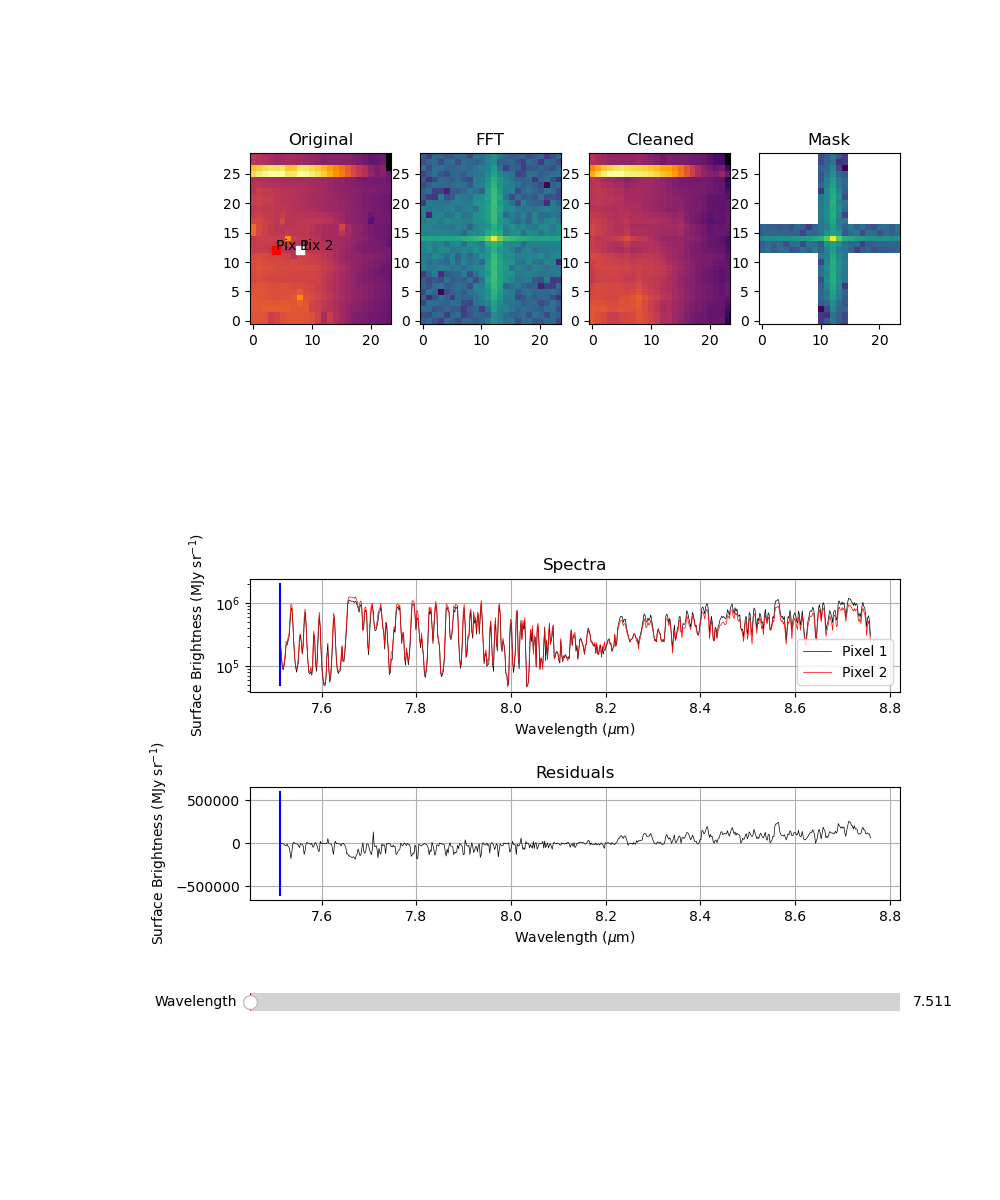

In [73]:
filename = 'JWSTData/1246_nav/ifu_align/Level3_ch2-short_s3d_nav_d1.fits'

hdul = fits.open(filename)
spec_data = hdul['SCI'].data
dz,dy,dx = spec_data.shape
spec_data=spec_data[:,1:dy-1,3:dx-2]

hdr = hdul['SCI'].header
hdul.close()

wave = np.arange(hdr['NAXIS3'])*hdr['CDELT3']+hdr['CRVAL3']

dz,dy,dx = spec_data.shape


# Extract spectra
flux_in = [None]*dz
flux_out = [None]*dz
difference = [None]*dz

for kk in range(dz):
    flux_in[kk] = spec_data[kk][12][4]   #MJy/sr
    flux_out[kk] = spec_data[kk][12][8] #MJy/sr

    difference[kk] = flux_in[kk] - flux_out[kk]
    
#    flux_in[kk] = flux_in[kk] * (1e+6)   #Jy/sr
#    flux_out[kk] = flux_out[kk] * (1e+6) #Jy/sr
    
print(flux_in[14])
print(flux_out[14])

magnitude_spectrum=np.empty(shape=(dz,dy,dx))
outimg=np.empty(shape=(dz,dy,dx))
magmask=np.empty(shape=(dz,dy,dx))
nw=len(wave)
for i in range(nw):
    img=spec_data[i]
    dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum[i] = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
    
    # # Central Cross Technique
    # create a mask first, center square is 1, remaining all zeros
    rows, cols = img.shape
    crow,ccol = rows//2 , cols//2
    mask = np.zeros((rows,cols,2),np.uint8)
    val=1
    mask[crow-val:crow+val+1, ccol-val:ccol+val+1] = 1
    val=2
    mask[crow-val:crow+val+1, 0:cols] = 1
    val=2
    mask[0:rows, ccol-val:ccol+val+1] = 1
    fshift = dft_shift*mask
    
    # # Highpass
    # rows, cols = img.shape
    # crow,ccol = rows//2 , cols//2
    # mask = np.ones((rows,cols,2),np.uint8)
    # val=10
    # mask[crow-val:crow+val+1, ccol-val:ccol+val+1] = 0
    # fshift = dft_shift*mask
    # # print(mask.shape)
    
    
# #     # CIRCLE FILTER
#     radius = 6
#     # mask = np.zeros_like(img)
#     mask = np.ones((rows,cols,2),np.uint8)
#     cy = mask.shape[0] // 2
#     cx = mask.shape[1] // 2
#     cv2.circle(mask, (cx,cy), radius, (255,255,255), -1)[0]
#     # mask = 255 - mask
#     # print(mask.shape)
    
#     fshift = dft_shift*mask / 255
    
    
#     # blur the mask
#     mask2 = cv2.GaussianBlur(mask, (5,5), 0)
#     fshift = dft_shift*mask2 / 255

    # apply mask and inverse DFT
    
    magnitude_fshift = 20*np.log(cv2.magnitude(fshift[:,:,0],fshift[:,:,1]))
    magmask[i]=magnitude_fshift
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
    
    outimg[i]=img_back

print(magnitude_spectrum.shape, spec_data.shape)
    
idx0 = 0

fig, ax = plt.subplots(3,figsize=(10,12),gridspec_kw={'height_ratios': [3,1,1]})
plt.subplots_adjust(left=0.25, bottom=0.25, hspace=0.5)

def f(idx):
    return wave[idx]


# Plot the original images
plt.subplot(341)

l = plt.imshow(spec_data[idx0],cmap='inferno',origin='lower', interpolation='None')
plt.plot(4,12,'rs')
plt.text(4,12,'Pix 1')
plt.plot(8,12,'ws')
plt.text(8,12,'Pix 2')
plt.title('Original')

# Now plot the spatial frequency spectrum

plt.subplot(342)
z1 = plt.imshow(magnitude_spectrum[idx0],cmap='viridis',origin='lower')
plt.title('FFT')


# Plot the cleaned image
plt.subplot(343)
z2 = plt.imshow(outimg[idx0],cmap='inferno',origin='lower')
plt.title('Cleaned')

# Plot the masked frequency spectrum

plt.subplot(344)
z3 = plt.imshow(magmask[idx0],cmap='viridis',origin='lower')
plt.title('Mask')

# Plot the spectrum

plt.subplot(312)
plt.plot(wave,flux_in,'k-',linewidth=0.5,label='Pixel 1')
plt.plot(wave,flux_out,'r-',linewidth=0.5,label='Pixel 2')
n, = plt.plot([f(idx0),f(idx0)],[5e+4,2e+6],'b-')
plt.legend()
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Surface Brightness (MJy sr$^{-1}$)')
plt.title('Spectra')
plt.yscale('log')
plt.grid()

# Plot the difference between spectra

plt.subplot(313)
plt.plot(wave,difference,'k-',linewidth=0.5)
m, = plt.plot([f(idx0),f(idx0)],[-600000,600000],'b-')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Surface Brightness (MJy sr$^{-1}$)')
plt.title('Residuals')
#plt.yscale('log')
plt.grid()


axidx = plt.axes([0.25, 0.15, 0.65, 0.03])
slidx = Slider(axidx, 'Wavelength', wave[0], wave[dz-1], valinit=wave[0], valfmt='%.3f')


def update(val):
    idx = find_nearest(wave,slidx.val)
    l.set_data(spec_data[int(idx)])
    l.set_clim(np.quantile(spec_data[int(idx)],0.2), np.nanmax(spec_data[int(idx)]))
    
    z1.set_data(magnitude_spectrum[int(idx)])
    z1.set_clim(np.nanmin(magnitude_spectrum[int(idx)]), np.nanmax(magnitude_spectrum[int(idx)]))
    
    z2.set_data(outimg[int(idx)])
    z2.set_clim(np.nanmin(outimg[int(idx)]), np.nanmax(outimg[int(idx)]))
    
    z3.set_data(magmask[int(idx)])
    z3.set_clim(np.nanmin(magnitude_spectrum[int(idx)]), np.nanmax(magnitude_spectrum[int(idx)]))
    
    # fig.set_title(str(wave[idx]))
    n.set_xdata([f(idx),f(idx)])
    m.set_xdata([f(idx),f(idx)])
    fig.canvas.draw_idle()
slidx.on_changed(update)


plt.show()